In [1]:
from __future__ import print_function
import datetime
from functools import reduce
import os

import pandas as pd
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [2]:
# Data collected from a spark query at CERN, in pandas pickle format
# CRAB jobs only have data after Oct. 2017
ws = pd.read_pickle("data/working_set_day.pkl.gz")
# spark returns lists, we want to use sets
ws['working_set_blocks'] = ws.apply(lambda x: set(x.working_set_blocks), 'columns')
ws['working_set'] = ws.apply(lambda x: set(x.working_set), 'columns')

In [3]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    blocksize = pd.read_csv("data/dbs_blocks.csv.gz", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a dictionary
blocksize = {v[0]:v[1] for v in blocksize}

In [4]:
# join the data tier definitions
datatiers = pd.read_csv('data/dbs_datatiers.csv').set_index('id')
ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values

In [5]:
date_index = np.arange(np.min(ws.day.values//86400), np.max(ws.day.values//86400)+1)
date_index_ts = np.array(list(datetime.date.fromtimestamp(day*86400) for day in date_index))

In [6]:
ws_filtered = ws[(ws.crab_job==True) & (ws.data_tier.str.contains('MINIAOD'))]

blocks_day = []
for i, day in enumerate(date_index):
    today = (ws_filtered.day==day*86400)
    blocks_day.append(reduce(lambda a,b: a.union(b), ws_filtered[today].working_set_blocks, set()))

print("Done assembling blocklists")

nrecords = np.zeros_like(date_index)
lifetimes = {
    '1w': 7,
    '1m': 30,
    '3m': 90,
    '6m': 120,
}
ws_size = {k: np.zeros_like(date_index) for k in lifetimes}
nrecalls = {k: np.zeros_like(date_index) for k in lifetimes}
recall_size = {k: np.zeros_like(date_index) for k in lifetimes}
previous = {k: set() for k in lifetimes}

for i, day in enumerate(date_index):
    nrecords[i] = ws_filtered[(ws_filtered.day==day*86400)].size
    for key in lifetimes:
        current = reduce(lambda a,b: a.union(b), blocks_day[max(0,i-lifetimes[key]):i+1], set())
        recall = current - previous[key]
        nrecalls[key][i] = len(recall)
        ws_size[key][i] = sum(blocksize[bid] for bid in current)
        recall_size[key][i] = sum(blocksize[bid] for bid in recall)
        previous[key] = current
    if i%30==0:
        print("Day ", i)

print("Done")

Done assembling blocklists
Day  0
Day  30
Day  60
Day  90
Day  120
Day  150
Day  180
Day  210
Day  240
Day  270
Day  300
Day  330
Day  360
Day  390
Day  420
Day  450
Day  480
Day  510
Day  540
Day  570
Day  600
Day  630
Day  660
Day  690
Day  720
Day  750
Done


<IPython.core.display.Javascript object>


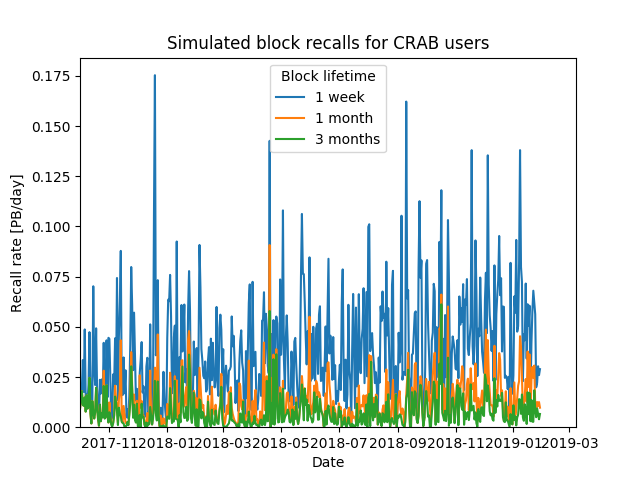

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(736603.0, 737126.0)

In [7]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, recall_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, recall_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, recall_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Simulated block recalls for CRAB users')
ax.set_ylabel('Recall rate [PB/day]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2017,10,1), None)

<IPython.core.display.Javascript object>


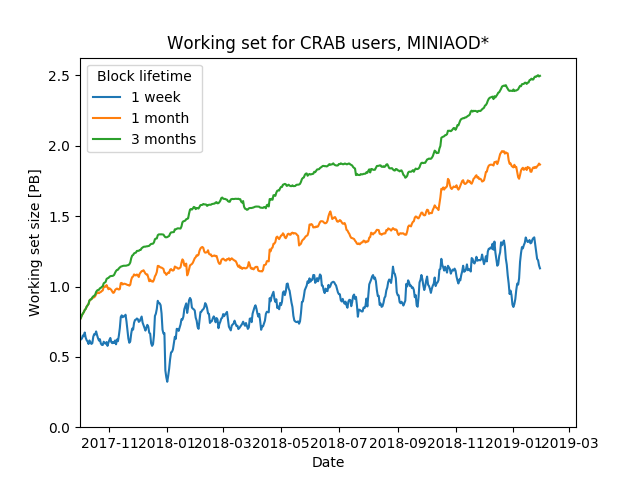

(736603.0, 737126.0)

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, ws_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, ws_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, ws_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Working set for CRAB users, MINIAOD*')
ax.set_ylabel('Working set size [PB]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2017,10,1), None)

In [9]:
recall_size['3m'].mean()/1e12

5.696515582485798

In [10]:
print(ws_filtered)

              day  d_data_tier_id  crab_job           input_campaign  \
29     1505779200           31223      True                 Run2017C   
36     1506556800           31224      True      PhaseIFall16MiniAOD   
41     1508025600           31223      True                 Run2016G   
43     1508630400           31223      True                 Run2016B   
51     1510099200           31223      True                 Run2016D   
53     1511136000           31223      True                 Run2017B   
59     1512777600           31223      True                 Run2017C   
64     1513900800           31224      True   RunIISpring16MiniAODv2   
65     1514505600           31223      True                 Run2017E   
69     1514937600           31224      True     RunIISummer17MiniAOD   
75     1515801600           31223      True                 Run2017F   
78     1516060800           31224      True   RunIISummer16MiniAODv2   
80     1516665600           31224      True   RunIISpring16MiniA

[10321 rows x 10 columns]


In [11]:
print(date_index_ts)

[datetime.date(2016, 12, 30) datetime.date(2016, 12, 31)
 datetime.date(2017, 1, 1) datetime.date(2017, 1, 2)
 datetime.date(2017, 1, 3) datetime.date(2017, 1, 4)
 datetime.date(2017, 1, 5) datetime.date(2017, 1, 6)
 datetime.date(2017, 1, 7) datetime.date(2017, 1, 8)
 datetime.date(2017, 1, 9) datetime.date(2017, 1, 10)
 datetime.date(2017, 1, 11) datetime.date(2017, 1, 12)
 datetime.date(2017, 1, 13) datetime.date(2017, 1, 14)
 datetime.date(2017, 1, 15) datetime.date(2017, 1, 16)
 datetime.date(2017, 1, 17) datetime.date(2017, 1, 18)
 datetime.date(2017, 1, 19) datetime.date(2017, 1, 20)
 datetime.date(2017, 1, 21) datetime.date(2017, 1, 22)
 datetime.date(2017, 1, 23) datetime.date(2017, 1, 24)
 datetime.date(2017, 1, 25) datetime.date(2017, 1, 26)
 datetime.date(2017, 1, 27) datetime.date(2017, 1, 28)
 datetime.date(2017, 1, 29) datetime.date(2017, 1, 30)
 datetime.date(2017, 1, 31) datetime.date(2017, 2, 1)
 datetime.date(2017, 2, 2) datetime.date(2017, 2, 3)
 datetime.date(2017,

In [13]:
# block_m_access is a set of blocks that have been accessed 
# in more than one day
block_m_access = set()

first = False
second = False
for day in block_dict:
    if first is False:
        block_m_access.update(block_set.intersection(block_dict[day]))
        first = True
    elif (second is False):
        block_m_access = (block_m_access.intersection(block_dict[day]))
        second = True
    else:
        block_m_access.update(block_m_access.intersection(block_dict[day]))
print("Done")

Done


In [14]:
print(block_m_access)

{16955392, 16984065, 16984064, 16984072, 16984075, 16984078, 16984080, 16984081, 17266715, 16977971, 17072181, 17072182, 17072183, 17072184, 17072196, 17072197, 17072198, 16941148, 16941150, 16941151, 16941152, 16941153, 16941156, 16941157, 16941158, 16941161, 16941162, 16941163, 16941165, 16941166, 16941167, 16941169, 17262745, 16937156, 16937159, 16937161, 16937166, 16937168, 16978146, 17266975, 16906568, 16941385, 16906570, 16941387, 16906572, 16906571, 16941390, 16906575, 16941392, 16906576, 16941394, 16906577, 16906578, 16941397, 16941399, 16941401, 16941403, 16941406, 16941407, 16941410, 16941418, 16941419, 16941421, 16941422, 17076619, 17076621, 17076622, 17076624, 17076626, 17076627, 17076631, 17076632, 17076634, 17076636, 17076637, 17076638, 17076640, 16986529, 17076641, 16986532, 16986534, 16986535, 16986536, 16986537, 16986538, 16986541, 16986545, 16986546, 16986547, 16986548, 16986550, 16986553, 16900540, 17267148, 17254884, 16929266, 16929267, 16929268, 16929271, 16929272,

In [15]:
# Initializes all of the access lists and timers
# "timers" are dictionaries with unique block keys and values that are
# lists

# block_access_timer
# keys are unique blocks
# values are the lists of times between first access and the subsequent accesses
block_access_timer = {}
for setBlock in block_set:
    block_access_timer[setBlock] = []
    
# block_first_access
# keys are unique blocks
# values are the time of first access
block_first_access = {}
for setBlock in block_set:
    block_first_access[setBlock] = 0
    
# block_sub_access
# keys are unique blocks
# values are the time of first access
block_sub_access = {}
for setBlock in block_set:
    block_sub_access[setBlock] = 0
    
# block_abs_access
# keys are unique blocks
# values are the day of access
block_abs_access_timer = {}
for setBlock in block_set:
    block_abs_access_timer[setBlock] = []

In [16]:
# Populates the dictionary, block_access_timer, with the time difference between the
# first access and each subsequent access
def accessTime(block, day):
    if (block_first_access[block] == 0):
        # This stores the inital time (time at which the block was first accessed)
        block_first_access[block] = day
    elif (block_first_access[block] != 0):
        block_sub_access[block] = day
        # Holds the time difference between the first access and each subsequent access
        block_access_timer[block].append(block_sub_access[block] - block_first_access[block])
    else:
        return
    
# Populates the dictionary, block_abs_access, with the day at which the block was 
# accessed
def absAccessTime(block, day):
    block_abs_access_timer[block].append(day)
    
# Removes all of the blocks that did not repeat
def removeTimerRedundancies(timer):
    for block in list(timer.keys()):
        if not timer[block]:
            timer.pop(block)
        
# Iterates over each day and for each block appends to its corresponding list every
# day for which it is accessed
first = False
block_t_access = set()
for day in block_dict:
    if first is False:
        block_t_access.update(block_set.intersection(block_dict[day]))
        first = True
        for block in block_t_access:
            accessTime(block, day)
            absAccessTime(block, day)
    else:
        block_t_access = (block_m_access.intersection(block_dict[day]))
        for block in block_t_access:
            accessTime(block, day)
            absAccessTime(block, day)
    if (day%50==0):
        print("Day", day)
print("Done")

# Removes all of the blocks that did not repeat
removeTimerRedundancies(block_access_timer)
removeTimerRedundancies(block_abs_access_timer)

Day 300
Day 350
Day 400
Day 450
Day 500
Day 550
Day 600
Day 650
Day 700
Day 750
Done


In [17]:
# block_diff_access_timer
# keys are unique blocks
# values are the difference between subsequent days of access
block_diff_access_timer = {}
for block in set(block_abs_access_timer.keys()):
    block_diff_access_timer[block] = []

# Populates block_diff_access_timer 
# Iterates through each block and takes the difference between the
# subsequent times of access
for block in list(block_abs_access_timer.keys()):
    block_diff_access_timer[block] = [block_abs_access_timer[block][i + 1]
                                      -block_abs_access_timer[block][i] 
                                      for i in range(len(block_abs_access_timer[block])-1)]

In [18]:
# Counts the number of blocks that have been accessed consecutively under 
# the given number of days
cons_occurrence_dict = {}
for block in list(block_diff_access_timer.keys()):
    if len(list(block_diff_access_timer[block])) > 0:
        threshold = max(block_diff_access_timer[block])
        if threshold in cons_occurrence_dict:
            for dayCount in range(0,threshold + 1):
                cons_occurrence_dict[dayCount] += 1
        else:
            for dayCount in range(0, threshold+1):
                cons_occurrence_dict[dayCount] = 1

cons_exact_occurrence_dict = {}
for block in list(block_diff_access_timer.keys()):
    if len(list(block_diff_access_timer[block])) > 0:
        threshold = max(block_diff_access_timer[block])
        if threshold in cons_exact_occurrence_dict:
            cons_exact_occurrence_dict[threshold] += 1
        else:
            cons_exact_occurrence_dict[threshold] = 1

<IPython.core.display.Javascript object>


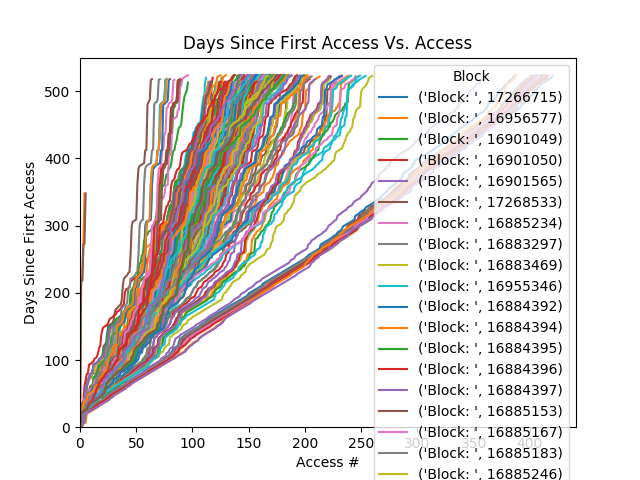

(0, 441.0)

In [19]:
fig, ax = plt.subplots(1,1)
i = np.arange(1,1000)
exampleList = list(block_access_timer.keys())
for block in list(block_access_timer.keys()):
    i = np.arange(0,len(block_access_timer[block]))
    ax.plot(i, block_access_timer[block], label=("Block: ", block))
ax.legend(title='Block')
ax.set_title('Days Since First Access Vs. Access')
ax.set_ylabel('Days Since First Access')
ax.set_xlabel('Access #')
ax.set_ylim(0, None)
ax.set_xlim(0, None)

<IPython.core.display.Javascript object>


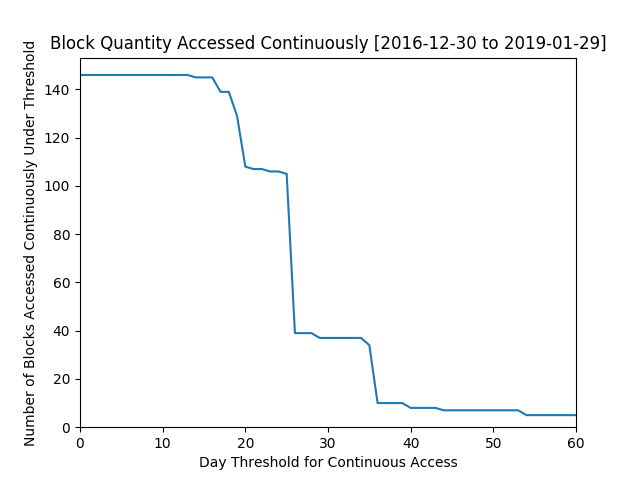

(0, 60)

In [24]:
fig, ax = plt.subplots(1,1)
ax.plot(sorted(cons_occurrence_dict.keys()), 
        list(cons_occurrence_dict.values()))
ax.set_title('Block Quantity Accessed Continuously [2016-12-30 to 2019-01-29]')
ax.set_ylabel('Number of Blocks Accessed Continuously Under Threshold')
ax.set_xlabel('Day Threshold for Continuous Access')
ax.set_ylim(0, None)
ax.set_xlim(0, 60)

<IPython.core.display.Javascript object>


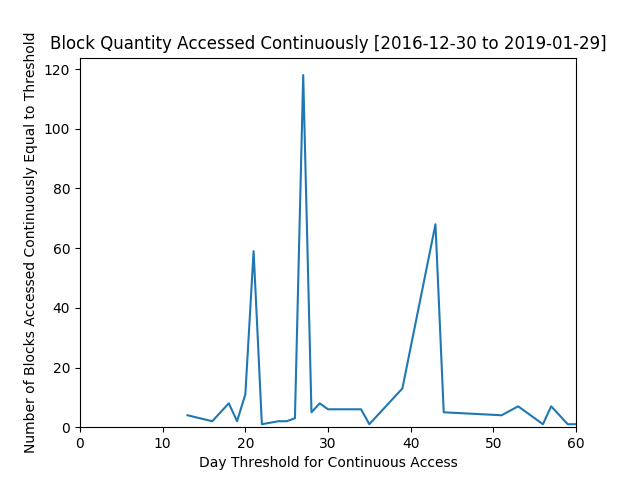

(0, 60)

In [25]:
fig, ax = plt.subplots(1,1)
ax.plot(sorted(cons_exact_occurrence_dict.keys()), 
        list(cons_exact_occurrence_dict.values()))
ax.set_title('Block Quantity Accessed Continuously [2016-12-30 to 2019-01-29]')
ax.set_ylabel('Number of Blocks Accessed Continuously Equal to Threshold')
ax.set_xlabel('Day Threshold for Continuous Access')
ax.set_ylim(0, None)
ax.set_xlim(0, 60)